Note: This script uses XGBoost, Matplotlib, and Seaborn.
Data loaded successfully.
Starting improved preprocessing...
Removed outliers. New train shape: (1458, 80)
Combined data shape: (2917, 79)
Creating new features...
Applied log transformation to 23 skewed features.
Normalizing data using StandardScaler...
Preprocessing complete. Final data shape: X=(1458, 311), X_test_competition=(1459, 311)

Data split into 70% train, 15% validation, 15% test sets.
Train set size: 1020 (70%)
Validation set size: 219 (15%)
Test set size: 219 (15%)

HYPERPARAMETER OPTIMIZATION EXPERIMENT
Testing optimized hyperparameters across lambda values

  Training models for L2 Lambda = 100

--- Final Test Set RMSE (Lambda = 100) ---
LightGBM: 0.11683
XGBoost:  0.11102
Blended:  0.11436

Top 10 Most Important Features:
       feature  importance
       TotalSF        1286
       LotArea        1211
     GrLivArea         947
    GarageArea         726
    BsmtFinSF1         692
Total_Porch_SF         650
    

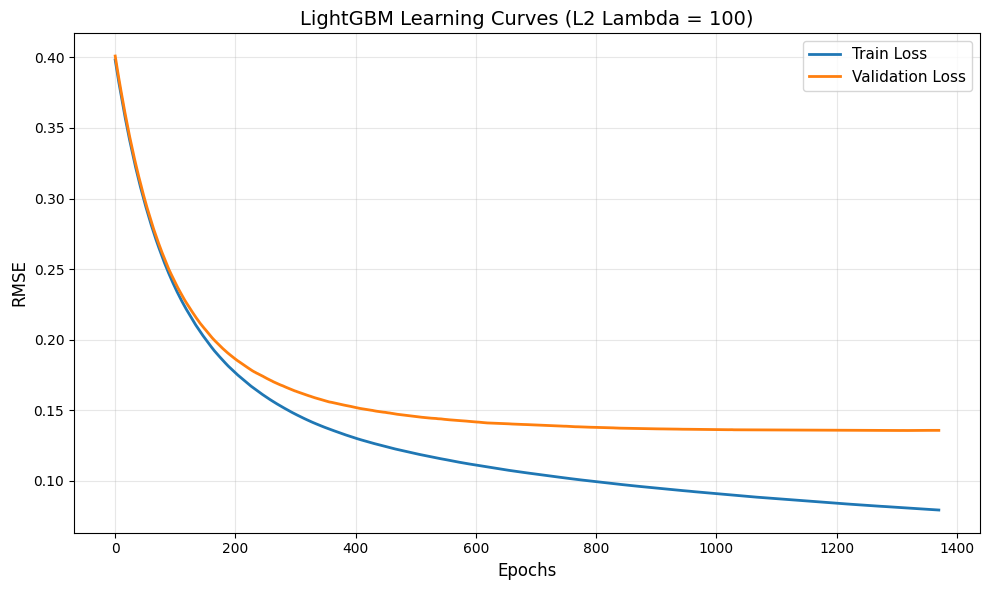


  Training models for L2 Lambda = 300

--- Final Test Set RMSE (Lambda = 300) ---
LightGBM: 0.11662
XGBoost:  0.11473
Blended:  0.11559

Top 10 Most Important Features:
    feature  importance
    TotalSF        1924
    LotArea        1800
  GrLivArea        1089
 BsmtFinSF1        1060
 GarageArea        1059
   1stFlrSF         895
  YearBuilt         853
  BsmtUnfSF         833
OverallCond         809
GarageYrBlt         800


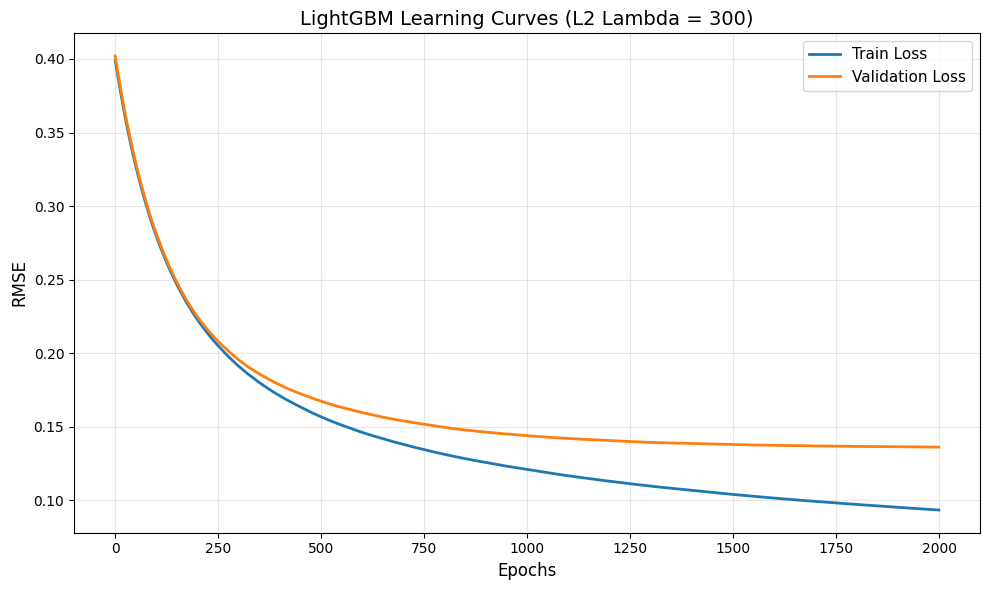


  Training models for L2 Lambda = 500

--- Final Test Set RMSE (Lambda = 500) ---
LightGBM: 0.12244
XGBoost:  0.12108
Blended:  0.12165

Top 10 Most Important Features:
    feature  importance
    TotalSF        2040
    LotArea        1731
 GarageArea        1083
 BsmtFinSF1         977
  GrLivArea         956
GarageYrBlt         841
  YearBuilt         839
OverallCond         809
OverallQual         742
   1stFlrSF         717


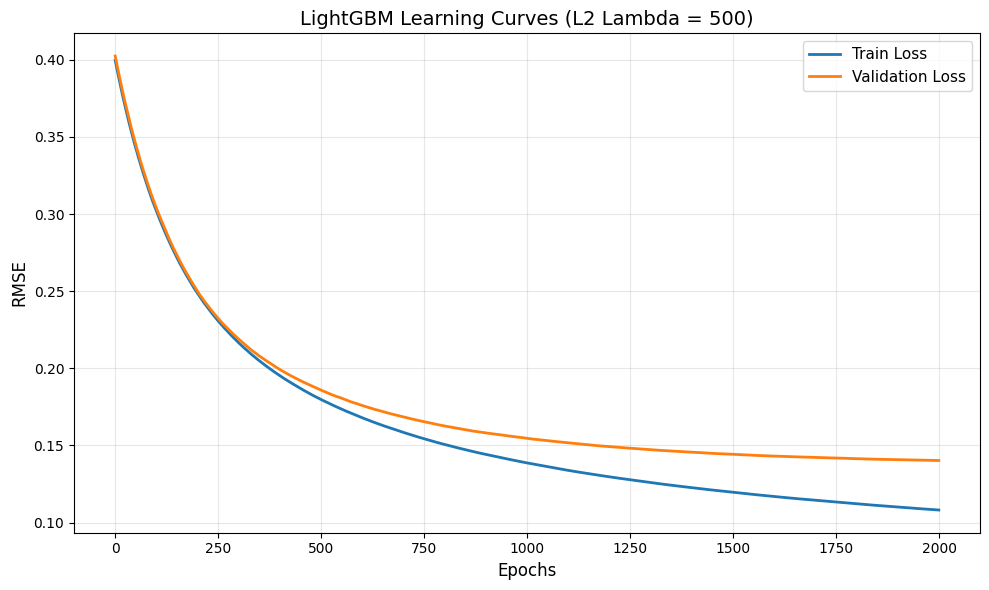


  Training models for L2 Lambda = 750

--- Final Test Set RMSE (Lambda = 750) ---
LightGBM: 0.13175
XGBoost:  0.12977
Blended:  0.13083

Top 10 Most Important Features:
        feature  importance
        TotalSF        2065
        LotArea        1649
     GarageArea        1030
     BsmtFinSF1         917
    GarageYrBlt         865
    OverallQual         846
    OverallCond         839
      YearBuilt         789
      GrLivArea         783
Total_Bathrooms         637


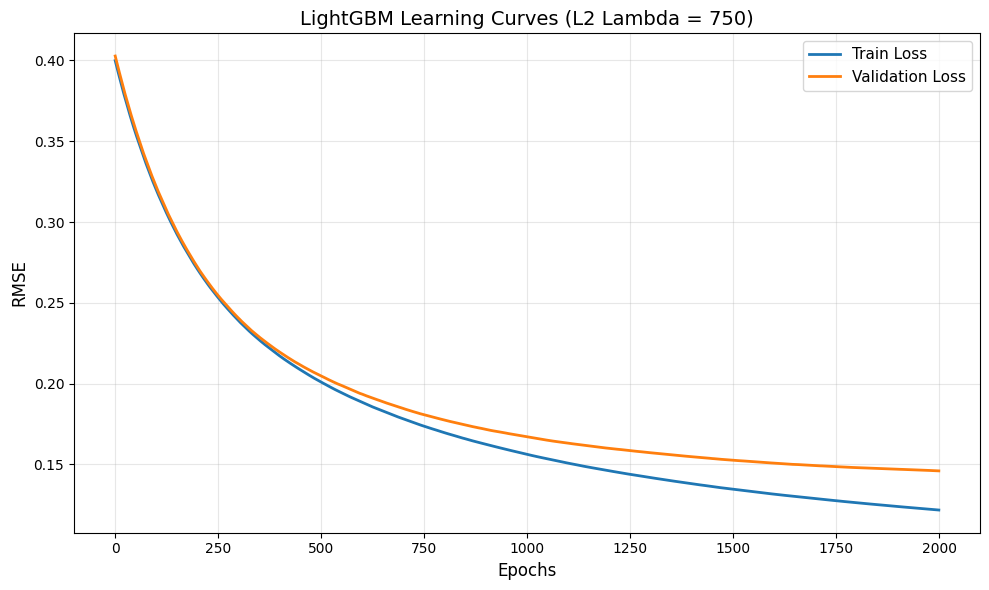


  Training models for L2 Lambda = 1000

--- Final Test Set RMSE (Lambda = 1000) ---
LightGBM: 0.14051
XGBoost:  0.13762
Blended:  0.13936

Top 10 Most Important Features:
        feature  importance
        TotalSF        2000
        LotArea        1606
     GarageArea         937
    OverallQual         924
     BsmtFinSF1         884
    OverallCond         858
    GarageYrBlt         846
      YearBuilt         811
      GrLivArea         657
Total_Bathrooms         632


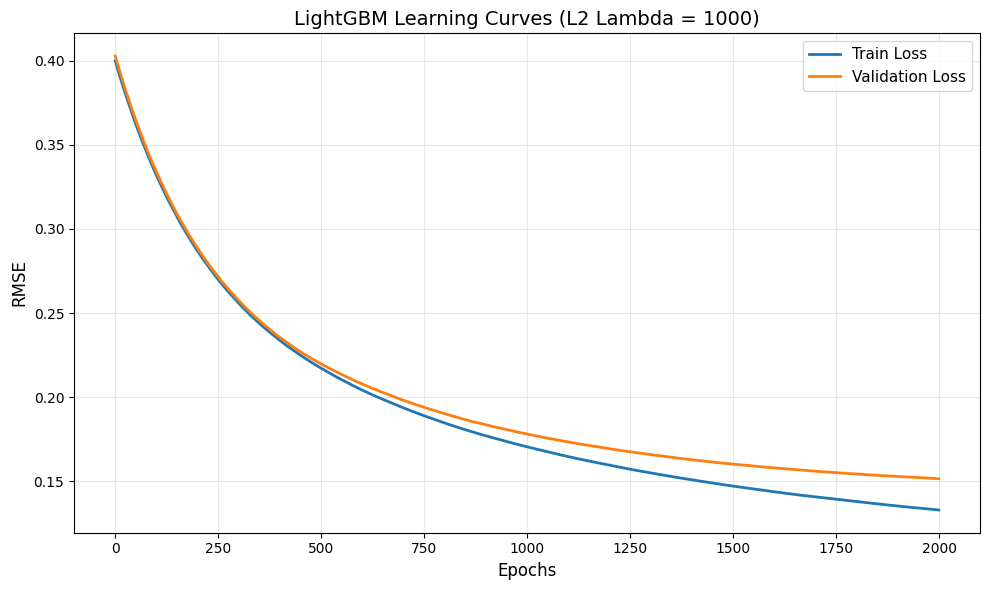


  Training models for L2 Lambda = 1500

--- Final Test Set RMSE (Lambda = 1500) ---
LightGBM: 0.15612
XGBoost:  0.15283
Blended:  0.15485

Top 10 Most Important Features:
        feature  importance
        TotalSF        1911
        LotArea        1576
    OverallQual        1034
     BsmtFinSF1         910
     GarageArea         830
    OverallCond         819
    GarageYrBlt         798
      YearBuilt         797
Total_Bathrooms         686
      GrLivArea         620


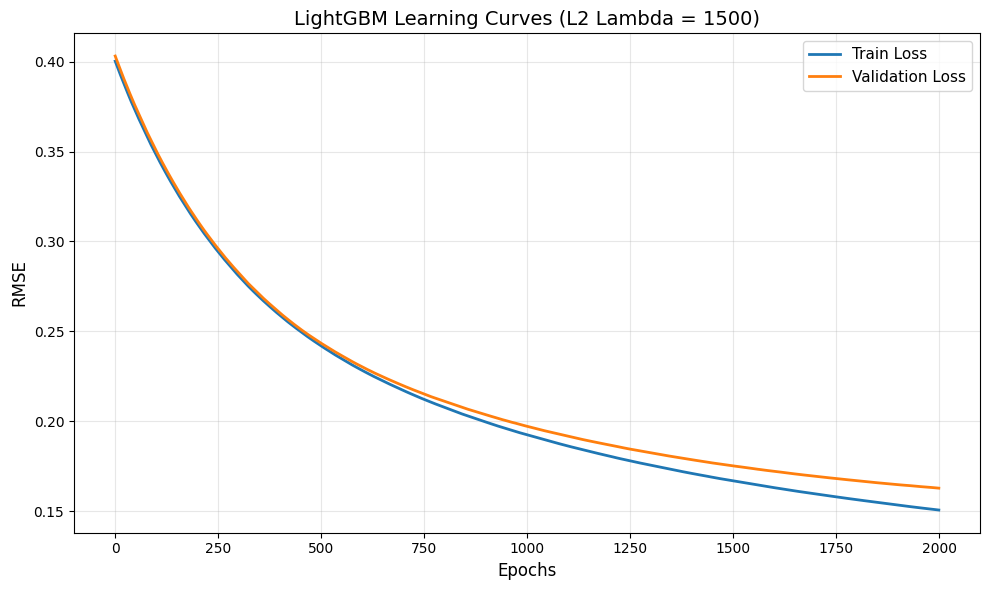


FINAL RESULTS SUMMARY
Best L2 Lambda: 100
Best Blended RMSE: 0.11436

Performance across all lambda values:
Lambda  100: LGB=0.11683, XGB=0.11102, Blended=0.11436
Lambda  300: LGB=0.11662, XGB=0.11473, Blended=0.11559
Lambda  500: LGB=0.12244, XGB=0.12108, Blended=0.12165
Lambda  750: LGB=0.13175, XGB=0.12977, Blended=0.13083
Lambda 1000: LGB=0.14051, XGB=0.13762, Blended=0.13936
Lambda 1500: LGB=0.15612, XGB=0.15283, Blended=0.15485


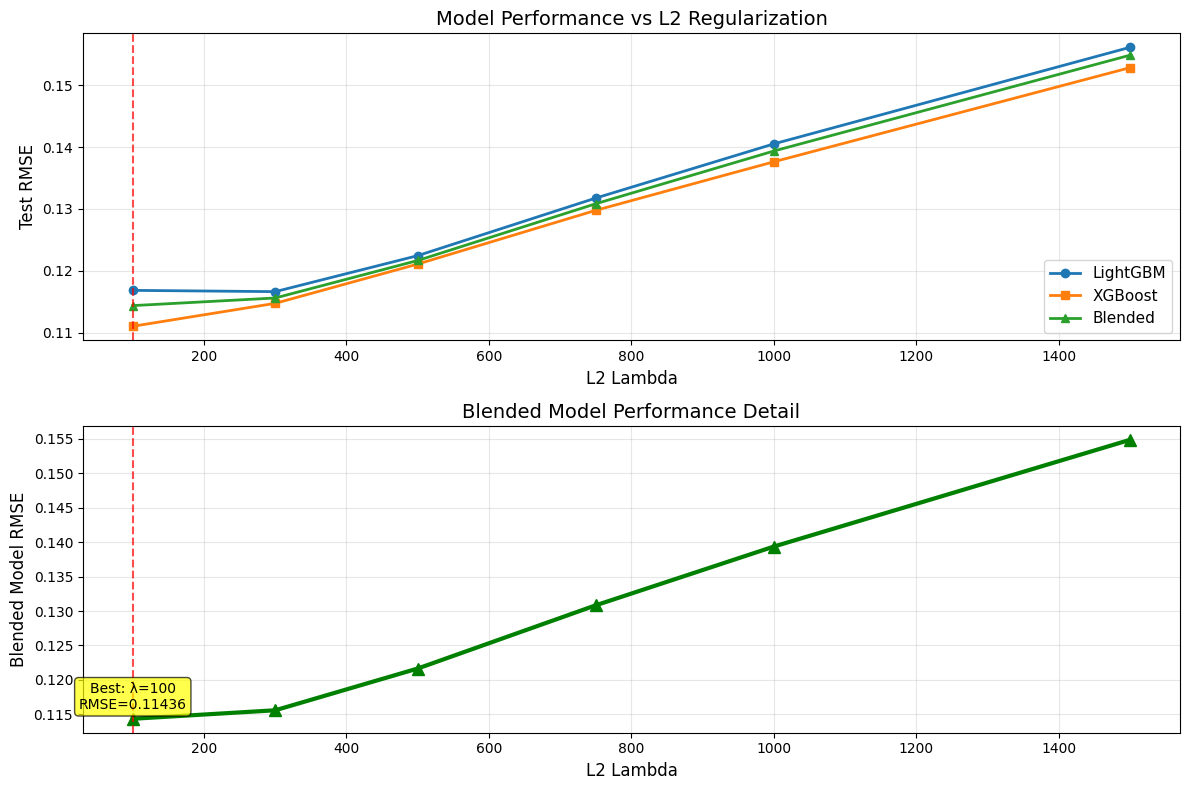


Competition predictions saved to 'house_price_predictions.csv'
Predictions summary:
Mean: $178,051.06
Median: $157,949.05
Min: $63,557.61
Max: $478,735.97

Top 15 Most Important Features (Best Model - Lambda 100):
       feature  importance
       TotalSF        1286
       LotArea        1211
     GrLivArea         947
    GarageArea         726
    BsmtFinSF1         692
Total_Porch_SF         650
      1stFlrSF         624
   GarageYrBlt         606
   OverallCond         587
     BsmtUnfSF         567
     YearBuilt         564
   LotFrontage         489
   OverallQual         463
   TotalBsmtSF         444
 YearRemod_Age         426


In [6]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import skew

# --- VISUALIZATION IMPORTS ---
import matplotlib.pyplot as plt
import seaborn as sns

# Add a note for the user about required libraries
print("Note: This script uses XGBoost, Matplotlib, and Seaborn.")


# --- 1. Data Loading ---
def load_data():
    """Loads the training and testing datasets."""
    try:
        train_df = pd.read_csv('train.csv')
        test_df = pd.read_csv('test.csv')
        print("Data loaded successfully.")
        return train_df, test_df
    except FileNotFoundError:
        print("Error: train.csv or test.csv not found.")
        print("Please ensure the data files are in the same directory as the script.")
        return None, None

# --- 2. Preprocessing and Feature Engineering ---
def preprocess(train_df, test_df):
    """Handles missing values, feature engineering, and normalization."""
    print("Starting improved preprocessing...")
    test_ids = test_df['Id']
    train_df = train_df.drop('Id', axis=1)
    test_df = test_df.drop('Id', axis=1)

    train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<300000)].index)
    print(f"Removed outliers. New train shape: {train_df.shape}")

    # The target variable is log-transformed
    train_df['SalePrice'] = np.log1p(train_df['SalePrice'])
    y = train_df['SalePrice']

    all_data = pd.concat((train_df.drop('SalePrice', axis=1), test_df))
    print(f"Combined data shape: {all_data.shape}")

    # Fill missing values
    for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType',
                'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
                'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'):
        all_data[col] = all_data[col].fillna('None')
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
                'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
        all_data[col] = all_data[col].fillna(0)
    for col in ('MSZoning', 'Utilities', 'Functional', 'Exterior1st', 'Exterior2nd',
                'KitchenQual', 'SaleType', 'Electrical'):
        all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
    all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
        lambda x: x.fillna(x.median()))

    # Feature Engineering
    print("Creating new features...")
    all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
    all_data['Total_Bathrooms'] = (all_data['FullBath'] + 0.5 * all_data['HalfBath'] +
                                   all_data['BsmtFullBath'] + 0.5 * all_data['BsmtHalfBath'])
    all_data['Total_Porch_SF'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
                                  all_data['EnclosedPorch'] + all_data['ScreenPorch'] +
                                  all_data['WoodDeckSF'])
    all_data['YearBuilt_Age'] = all_data['YrSold'] - all_data['YearBuilt']
    all_data['YearRemod_Age'] = all_data['YrSold'] - all_data['YearRemodAdd']
    all_data['haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

    # Skewness Transform
    numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
    skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna()))
    skewed_feats = skewed_feats[skewed_feats > 0.75].index
    all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
    print(f"Applied log transformation to {len(skewed_feats)} skewed features.")

    # One-Hot Encoding
    all_data = pd.get_dummies(all_data)

    # Separate train and competition test data
    X = all_data[:len(y)]
    X_test_competition = all_data[len(y):]

    # Normalize all features using StandardScaler
    print("Normalizing data using StandardScaler...")
    scaler = StandardScaler()
    
    # Fit the scaler ONLY on the training data to avoid data leakage
    scaler.fit(X)
    
    # Transform both the training and competition test data
    X_scaled = scaler.transform(X)
    X_test_competition_scaled = scaler.transform(X_test_competition)
    
    # Convert scaled arrays back to DataFrames, preserving columns and index
    X = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
    X_test_competition = pd.DataFrame(X_test_competition_scaled, index=X_test_competition.index, columns=X_test_competition.columns)
    
    print(f"Preprocessing complete. Final data shape: X={X.shape}, X_test_competition={X_test_competition.shape}")
    return X, y, X_test_competition, test_ids


# --- VISUALIZATION FUNCTIONS ---
def plot_learning_curves(lgb_evals, l2_lambda):
    """Plots the training and validation loss for LightGBM for a given lambda."""
    plt.figure(figsize=(10, 6))
    lgb_train_loss = lgb_evals['training']['rmse']
    lgb_val_loss = lgb_evals['valid_1']['rmse']
    plt.plot(lgb_train_loss, label='Train Loss', linewidth=2)
    plt.plot(lgb_val_loss, label='Validation Loss', linewidth=2)
    plt.title(f'LightGBM Learning Curves (L2 Lambda = {l2_lambda})', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('RMSE', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_lambda_comparison(results):
    """Plots RMSE comparison across different lambda values."""
    plt.figure(figsize=(12, 8))
    
    lambdas = list(results.keys())
    lgb_rmse = [results[l]['LightGBM'] for l in lambdas]
    xgb_rmse = [results[l]['XGBoost'] for l in lambdas]
    blended_rmse = [results[l]['Blended'] for l in lambdas]
    
    plt.subplot(2, 1, 1)
    plt.plot(lambdas, lgb_rmse, 'o-', label='LightGBM', linewidth=2, markersize=6)
    plt.plot(lambdas, xgb_rmse, 's-', label='XGBoost', linewidth=2, markersize=6)
    plt.plot(lambdas, blended_rmse, '^-', label='Blended', linewidth=2, markersize=6)
    plt.xlabel('L2 Lambda', fontsize=12)
    plt.ylabel('Test RMSE', fontsize=12)
    plt.title('Model Performance vs L2 Regularization', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # Find and highlight the best lambda for each model
    best_lgb_lambda = min(lambdas, key=lambda l: results[l]['LightGBM'])
    best_xgb_lambda = min(lambdas, key=lambda l: results[l]['XGBoost'])
    best_blended_lambda = min(lambdas, key=lambda l: results[l]['Blended'])
    
    plt.axvline(best_blended_lambda, color='red', linestyle='--', alpha=0.7, label=f'Best Blended (λ={best_blended_lambda})')
    
    plt.subplot(2, 1, 2)
    plt.plot(lambdas, blended_rmse, '^-', color='green', linewidth=3, markersize=8)
    plt.xlabel('L2 Lambda', fontsize=12)
    plt.ylabel('Blended Model RMSE', fontsize=12)
    plt.title('Blended Model Performance Detail', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.axvline(best_blended_lambda, color='red', linestyle='--', alpha=0.7)
    plt.text(best_blended_lambda, min(blended_rmse) + 0.001, f'Best: λ={best_blended_lambda}\nRMSE={min(blended_rmse):.5f}', 
             ha='center', va='bottom', fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
    
    plt.tight_layout()
    plt.show()

# --- 3. Model Training and Evaluation with Optimized Hyperparameters ---
def train_and_evaluate_for_lambda(l2_lambda, X_train, y_train, X_val, y_val, X_test, y_test):
    """Trains and evaluates models for a specific L2 lambda value with optimized hyperparameters."""
    print(f"\n===============================================")
    print(f"  Training models for L2 Lambda = {l2_lambda}")
    print(f"===============================================")
    
    lgb_evals = {}
    
    # --- Optimized LightGBM Model ---
    lgb_model = lgb.LGBMRegressor(
        objective='regression', 
        metric='rmse', 
        n_estimators=2000,
        learning_rate=0.015,  # Slightly increased from 0.01
        feature_fraction=0.8, 
        bagging_fraction=0.8,
        bagging_freq=1, 
        lambda_l1=0.1, 
        lambda_l2=l2_lambda,
        num_leaves=50,  # Increased from 31
        min_data_in_leaf=20,  # Added to prevent overfitting
        max_depth=6,  # Added explicit depth control
        verbose=-1, 
        n_jobs=-1, 
        seed=42
    )
    lgb_model.fit(X_train, y_train, 
                  eval_set=[(X_train, y_train), (X_val, y_val)],
                  eval_metric='rmse', 
                  callbacks=[lgb.early_stopping(50, verbose=False),  # Reduced from 100
                             lgb.record_evaluation(lgb_evals)])

    # --- Optimized XGBoost Model ---
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror', 
        eval_metric='rmse', 
        n_estimators=2000,
        learning_rate=0.015,  # Slightly increased from 0.01
        max_depth=5,  # Increased from 4
        subsample=0.8,
        colsample_bytree=0.8, 
        reg_lambda=l2_lambda,
        reg_alpha=0.1,  # Added L1 regularization
        min_child_weight=3,  # Added to prevent overfitting
        random_state=42, 
        n_jobs=-1
    )
    
    # Try different fitting approaches based on XGBoost version
    try:
        # For newer XGBoost versions
        xgb_model.fit(X_train, y_train, 
                      eval_set=[(X_train, y_train), (X_val, y_val)],
                      callbacks=[xgb.callback.EarlyStopping(rounds=50, save_best=True)],
                      verbose=False)
    except (AttributeError, TypeError):
        # For older XGBoost versions
        try:
            xgb_model.fit(X_train, y_train, 
                          eval_set=[(X_train, y_train), (X_val, y_val)],
                          early_stopping_rounds=50,
                          verbose=False)
        except TypeError:
            # Fallback - no early stopping
            print(f"Warning: Early stopping not available for XGBoost. Training without early stopping for lambda={l2_lambda}")
            xgb_model.fit(X_train, y_train, verbose=False)

    # --- Evaluate on the Hold-Out Test Set ---
    preds_lgb = lgb_model.predict(X_test)
    preds_xgb = xgb_model.predict(X_test)
    blended_preds = 0.7 * preds_lgb + 0.3 * preds_xgb
    
    rmse_lgb = np.sqrt(mean_squared_error(y_test, preds_lgb))
    rmse_xgb = np.sqrt(mean_squared_error(y_test, preds_xgb))
    rmse_blended = np.sqrt(mean_squared_error(y_test, blended_preds))
    
    print(f"\n--- Final Test Set RMSE (Lambda = {l2_lambda}) ---")
    print(f"LightGBM: {rmse_lgb:.5f}")
    print(f"XGBoost:  {rmse_xgb:.5f}")
    print(f"Blended:  {rmse_blended:.5f}")
    
    # --- Feature Importance Analysis ---
    feature_importance = lgb_model.feature_importances_
    feature_names = X_train.columns
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 10 Most Important Features:")
    print(importance_df.head(10).to_string(index=False))
    
    # --- Visualize Results ---
    plot_learning_curves(lgb_evals, l2_lambda)
    
    return {
        'LightGBM': rmse_lgb,
        'XGBoost': rmse_xgb,
        'Blended': rmse_blended,
        'models': (lgb_model, xgb_model),
        'feature_importance': importance_df
    }

def generate_competition_predictions(best_models, X_test_competition, test_ids):
    """Generates predictions for the competition test set using the best models."""
    lgb_model, xgb_model = best_models
    
    # Make predictions
    preds_lgb = lgb_model.predict(X_test_competition)
    preds_xgb = xgb_model.predict(X_test_competition)
    blended_preds = 0.7 * preds_lgb + 0.3 * preds_xgb
    
    # Transform back from log space
    final_preds = np.expm1(blended_preds)
    
    # Create submission dataframe
    submission = pd.DataFrame({
        'Id': test_ids,
        'SalePrice': final_preds
    })
    
    # Save to CSV
    submission.to_csv('house_price_predictions.csv', index=False)
    print(f"\nCompetition predictions saved to 'house_price_predictions.csv'")
    print(f"Predictions summary:")
    print(f"Mean: ${final_preds.mean():,.2f}")
    print(f"Median: ${np.median(final_preds):,.2f}")
    print(f"Min: ${final_preds.min():,.2f}")
    print(f"Max: ${final_preds.max():,.2f}")

# --- Main Execution ---
if __name__ == '__main__':
    train_df, test_df = load_data()
    if train_df is not None and test_df is not None:
        X, y, X_test_competition, test_ids = preprocess(train_df, test_df)
        
        # Create the 70-15-15 split
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

        print("\nData split into 70% train, 15% validation, 15% test sets.")
        print(f"Train set size: {len(X_train)} ({len(X_train)/len(X)*100:.0f}%)")
        print(f"Validation set size: {len(X_val)} ({len(X_val)/len(X)*100:.0f}%)")
        print(f"Test set size: {len(X_test)} ({len(X_test)/len(X)*100:.0f}%)")
        
        # Extended lambda range based on the good results with lambda=500
        lambdas = [100, 300, 500, 750, 1000, 1500]
        results = {}
        
        print("\n" + "="*60)
        print("HYPERPARAMETER OPTIMIZATION EXPERIMENT")
        print("Testing optimized hyperparameters across lambda values")
        print("="*60)
        
        for l2_lambda in lambdas:
            result = train_and_evaluate_for_lambda(l2_lambda, X_train, y_train, X_val, y_val, X_test, y_test)
            results[l2_lambda] = result
        
        # Find the best lambda and models
        best_lambda = min(lambdas, key=lambda l: results[l]['Blended'])
        best_models = results[best_lambda]['models']
        
        print("\n" + "="*60)
        print("FINAL RESULTS SUMMARY")
        print("="*60)
        print(f"Best L2 Lambda: {best_lambda}")
        print(f"Best Blended RMSE: {results[best_lambda]['Blended']:.5f}")
        print("\nPerformance across all lambda values:")
        for l in lambdas:
            print(f"Lambda {l:4d}: LGB={results[l]['LightGBM']:.5f}, XGB={results[l]['XGBoost']:.5f}, Blended={results[l]['Blended']:.5f}")
        
        # Plot comparison
        plot_lambda_comparison(results)
        
        # Generate competition predictions using the best models
        generate_competition_predictions(best_models, X_test_competition, test_ids)
        
        # Show feature importance from the best model
        print(f"\nTop 15 Most Important Features (Best Model - Lambda {best_lambda}):")
        print(results[best_lambda]['feature_importance'].head(15).to_string(index=False))